In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread('../src/buildingRGB.jpg')

# Display the image
cv2.imshow('Image', image)

# Wait for a mouse click
def get_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print("Coordinates (x, y):", x, y)

cv2.setMouseCallback('Image', get_coordinates)

cv2.waitKey(0)
cv2.destroyAllWindows()


Coordinates (x, y): 457 538
Coordinates (x, y): 435 530
Coordinates (x, y): 427 611
Coordinates (x, y): 444 693
Coordinates (x, y): 434 705
Coordinates (x, y): 656 761
Coordinates (x, y): 608 510


In [34]:
def AffineRecover(point, l1, l2, l3):
    Hpt = np.array([
        [1, 0,  -l1/l3],
        [0, 1,  -l2/l3],
        [0, 0,  1/l3]
    ]).astype('float32')
    
    Hprime = affinity() @ np.linalg.inv(Hpt).T
   
    transform_point= Hprime @ np.array(point).T
    # if transform_point[2] == 0: transform_point[2] = 1
    transform_point = [transform_point[0]/transform_point[2], transform_point[1]/transform_point[2], 1]
    return transform_point

def affinity(theta=0, phi=0, lambda1=1, lambda2=1, tx=0, ty=0):
    D = np.array([
        [lambda1, 0],
        [0, lambda2]
    ]).astype('float32')
    A = R(theta) @ R(-phi) @ D @ R(phi)
    aff_mat = np.array([
        [A[0][0], A[0][1], tx],
        [A[1][0], A[1][1], ty],
        [0,       0,        1]
    ])
    return aff_mat
    
def R(angle):
    angle = np.pi * angle / 180
    R = np.array([
        [np.cos(angle), -1*np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return R

In [57]:
p1 = [530, 435, 1]
p2 = [510, 608, 1]
p3 = [705, 434, 1]
p4 = [761, 656, 1]

l1=np.cross(p1,p2).astype('float32')
l2=np.cross(p3,p4).astype('float32')

l3=np.cross(p1,p3).astype('float32')
l4=np.cross(p2,p4).astype('float32')

point1=np.cross(l1,l2).astype('float32')
point2=np.cross(l3,l4).astype('float32')

L=np.cross(point1,point2).astype('float32')
L[0]=L[0]/L[2]
L[1]=L[1]/L[2]
L[2]=1
print(L)

[-0.00198756 -0.00393306  1.        ]


(933, 700)
[[100 100 100 ...  95 102 106]
 [100 100 100 ...  95 102 106]
 [100 100 100 ...  98 102 106]
 ...
 [ 30  30  29 ... 100  98 101]
 [ 29  29  28 ... 102  99 102]
 [ 32  30  27 ... 105 100 102]]


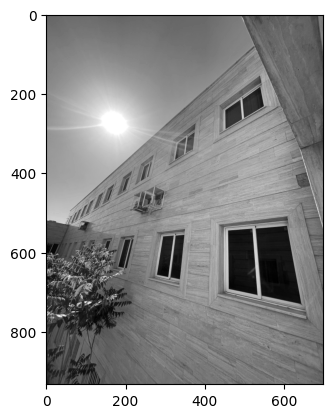

In [54]:
import cv2
image = cv2.imread('../src/buildingRGB.jpg')
im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(im.shape)
print(im)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.show()

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 193 193 193]
 [  0   0   0 ... 193 193 193]
 [  0   0   0 ... 194 193 193]]


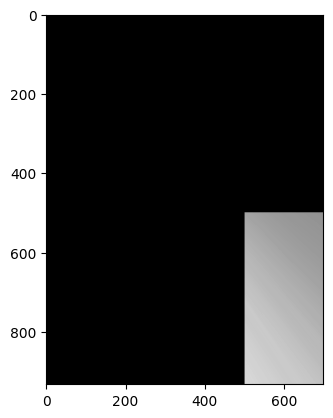

In [60]:
def AffineRecoverInv(point, l1, l2, l3):
    Hpt = np.array([
        [1, 0,  -l1/l3],
        [0, 1,  -l2/l3],
        [0, 0,  1/l3]
    ]).astype('float32')
    
    Hprime = affinity() @ np.linalg.inv(Hpt).T

    transform_point = np.linalg.inv(Hprime) @ np.array(point)
    if transform_point[2] == 0: transform_point[2] = 1
    transform_point = [transform_point[0]/transform_point[2], transform_point[1]/transform_point[2], 1]
    return transform_point[0], transform_point[1]

def affinity(theta=0, phi=0, lambda1=.1, lambda2=.1, tx=0, ty=0):
    D = np.array([
        [lambda1, 0],
        [0, lambda2]
    ])
    A = R(theta) @ R(-phi) @ D @ R(phi)
    aff_mat = np.array([
        [A[0][0], A[0][1], tx],
        [A[1][0], A[1][1], ty],
        [0,       0,        1]
    ])
    return aff_mat
    
def R(angle):
    angle = np.pi * angle / 180
    R = np.array([
        [np.cos(angle), -1*np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return R

new_img_type = np.zeros_like(im)
for i in range(500, im.shape[0]):
    for j in range(500, im.shape[1]):
        i_im, j_im = AffineRecoverInv([i,j,1],L[0],L[1],L[2])
        # print(i_im,j_im)
        if 0<i_im < im.shape[0]-1 and 0<j_im < im.shape[1]-1:
            new_img_type[i,j] = im[round(i_im), round(j_im)]

print(new_img_type)
plt.imshow(new_img_type, cmap='gray', vmin=0, vmax=255)
plt.show()

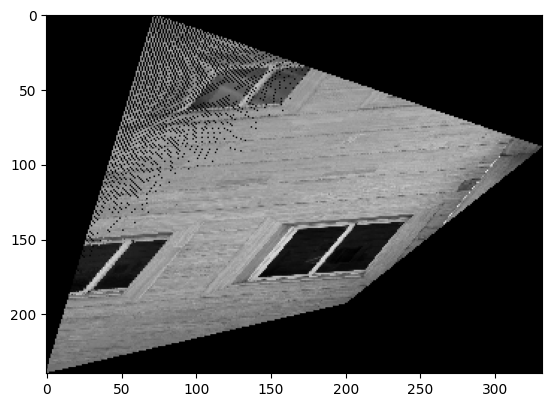

In [58]:
new_img_type = []
for i in range(300,933):
    for j in range(300, 700):
        new_point = AffineRecover([i,j,1],L[0],L[1],L[2])
        i_new = int(new_point[0])
        j_new = int(new_point[1])
        new_img_type.append([i_new, j_new, im[i][j]])
new_img_type = np.array(new_img_type)
X, Y, C = zip(*new_img_type)

X -= np.min(X)
Y -= np.min(Y)

X = np.array(X)
Y = np.array(Y)
C = np.array(C)

# normaled_X = np.where(X>0)

# X = X[normaled_X]
# Y = Y[normaled_X]
# C = C[normaled_X]

# normaled_Y = np.where(Y>0)

# X = X[normaled_Y]
# Y = Y[normaled_Y]
# C = C[normaled_Y]


normaled_X = np.where(X<5000)

X = X[normaled_X]
Y = Y[normaled_X]
C = C[normaled_X]

normaled_Y = np.where(Y<5000)

X = X[normaled_Y]
Y = Y[normaled_Y]
C = C[normaled_Y]




matrix_shape = (np.max(X) + 1, np.max(Y) + 1)
result_matrix = np.zeros(matrix_shape)


result_matrix[X, Y] = C

result_matrix = np.array(result_matrix).T
# result_matrix = result_matrix[:300, :300]

plt.imshow(result_matrix, cmap='gray', vmin=0, vmax=255)
plt.show()
